# **Libraries**

In [1]:
import sys
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data as data
from torch.nn.utils.rnn import pad_sequence

import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **Working with data**

In [3]:
class ReverseDataset(data.Dataset):
    def __init__(self, vocab_size, seq_len, size):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(3, self.vocab_size, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))

        inp_data = torch.Tensor(
            [1] + inp_data.tolist() + [2]
        ).type("torch.LongTensor")
        labels = torch.Tensor(
            [1] + labels.tolist() + [2]
        ).type("torch.LongTensor")

        return inp_data, labels

In [4]:
MAX_SEQ_LEN = 20

In [5]:
batch_size = 64
train_data_size = 100000
vocab_size = 5000

In [6]:
train_loader = data.DataLoader(
    ReverseDataset(vocab_size, 8, train_data_size),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)

In [7]:
print("Data example")
print("src:", train_loader.dataset[0][0])
print("tgt:", train_loader.dataset[0][1])

Data example
src: tensor([   1, 3661, 3166, 4952, 3985, 3580, 2482, 3609, 2959,    2])
tgt: tensor([   1, 2959, 3609, 2482, 3580, 3985, 4952, 3166, 3661,    2])


# **Model components**

In [8]:
class Sublayer(nn.Module):
    def __init__(self, d_model, dropout_p):
        super(Sublayer, self).__init__()

        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.layer_norm(x)))

## **Embedding**

In [9]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super(Embedding, self).__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.embedding(x) * np.sqrt(self.d_model)

## **Positional encoding**

In the paper, you can see that positional encoding is defined like this

$$\text{PE}_{(\text{pos}, 2i)} = \sin(\text{pos} / 10000^{2i / d_\text{model}})$$
$$\text{PE}_{(\text{pos}, 2i+1)} = \cos(\text{pos} / 10000^{2i / d_\text{model}})$$

Thanks [ARUNMOHAN_003](https://www.kaggle.com/arunmohan003)

In [10]:
class Positional_encoding(nn.Module):
    def __init__(self, d_model):
        super(Positional_encoding, self).__init__()

        self.d_model = d_model
        
        pos_enc = torch.zeros(MAX_SEQ_LEN, self.d_model).to(device)

        for position in range(MAX_SEQ_LEN):
            for i in range(0, self.d_model, 2):
                pos_enc[position, i] = np.sin(
                    position / (10000 ** ((2 * i) / self.d_model))
                )
                pos_enc[position, i + 1] = np.cos(
                    position / (10000 ** ((2 * (i + 1)) / self.d_model))
                )

        pos_enc = pos_enc.unsqueeze(0)

        self.register_buffer('positional_encoding', pos_enc)

    def forward(self, x):
        x = x + np.sqrt(self.d_model)

        len_x = x.size(1)

        x += torch.autograd.Variable(
            self.positional_encoding[:, :len_x],
            requires_grad=False
        ).to(device)
        
        return x

## **Positionwise FFN**

Following the original article, PositionwiseFFN is defined as:

$$\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2.$$

In [11]:
class PositionwiseFFN(nn.Module):
    def __init__(self, d_model, d_ffn, dropout_p):
        super(PositionwiseFFN, self).__init__()

        self.FFN = nn.Sequential(
            nn.Linear(d_model, d_ffn),
            nn.ReLU(inplace=True),
            nn.Linear(d_ffn, d_model)
        )

        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        return self.dropout(self.FFN(x))

## **Multihead attention**




### **Scaled dot product attention**

Scaled dot product attention it is calculated according to the formula (see the article [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf))

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^{T}}{\sqrt{d_k}}\right)V,$$

where $\sqrt{d_k}$ is a square root of queries and keys dimension.

Here is the scaled dot product attention scheme from [original article](https://arxiv.org/pdf/1706.03762.pdf):

![Scaled Dot-Product Attention.svg](https://svgshare.com/i/u4z.svg)

In [12]:
def scaled_dot_product_attn(Q, K, V, mask=None):
    d_k = Q.size(-1)

    attn_weights = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(d_k)

    if mask is not None:
        attn_weights = attn_weights.masked_fill(mask==0, -np.inf)

    attn_weights = attn_weights.softmax(dim=-1)

    attn_applied = torch.matmul(attn_weights, V)

    return attn_applied, attn_weights

### **Multihead attention**

Following the original article, multihead attention is defined as:

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_{1}, \text{...}, \text{head}_{h})W^O,$$

where

$$\text{head}_i = \text{Attention}(QW_{i}^{Q}, KW_{i}^{K}, VW_{i}^{V}).$$

Here is the multihead attention scheme:

![Multi-Head Attention.svg](https://svgshare.com/i/u6C.svg)

In [13]:
class MultiheadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout_p):
        super(MultiheadAttention, self).__init__()

        assert (
            d_model % n_heads == 0
        ), "d_head * n_heads must be equal to d_model!"

        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.attn_weights = None

    def forward(self, Q, K, V, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)

        batch_size = Q.size(0)

        Q = self.W_q(Q)
        K = self.W_k(K)
        V = self.W_v(V)

        Q = Q.view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)
        K = K.view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)
        V = V.view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)

        attention, self.attn_weights = scaled_dot_product_attn(Q, K, V, mask)

        attention = attention.transpose(1, 2).contiguous()
        attention = attention.view(batch_size, -1, self.n_heads * self.d_head)

        attention = self.W_o(attention)

        return attention

## **Encoder**

### **Encoder block**

Here is the block of encoder scheme:

![Encoder block.svg](https://svgshare.com/i/u5x.svg)

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self, self_attn, FFN, d_model, dropout_p):
        super(EncoderLayer, self).__init__()

        self.self_attn = self_attn
        self.FFN = FFN

        self.sublayer = Sublayer(d_model, dropout_p)

    def forward(self, x, src_mask):
        x = self.sublayer(x, lambda x: self.self_attn(x, x, x, src_mask))
        x = self.sublayer(x, self.FFN)
        return x

### **Full encoder**

Here is the full encoder scheme:

![Encoder.svg](https://svgshare.com/i/u55.svg)

In [15]:
class Encoder(nn.Module):
    def __init__(self, encoder_layer, emb, pos_enc, n_layers):
        super(Encoder, self).__init__()

        self.emb = emb
        self.pos_enc = pos_enc

        self.encoder_layers = nn.ModuleList([
            copy.deepcopy(encoder_layer)
            for _ in range(n_layers)
        ])

    def forward(self, x, src_mask):
        x = self.pos_enc(self.emb(x))
        
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, src_mask)
        
        return x

## **Decoder**

### **Decoder block**

Here is the block of decoder scheme:

![Decoder block.svg](https://svgshare.com/i/u5X.svg)

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, self_attn, cross_attn, FFN, d_model, dropout_p):
        super(DecoderLayer, self).__init__()

        self.self_attn = self_attn
        self.cross_attn = cross_attn
        self.FFN = FFN

        self.sublayer = Sublayer(d_model, dropout_p)

    def forward(self, x, encoder_out, src_mask, tgt_mask):
        m = encoder_out

        x = self.sublayer(x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer(x, lambda x: self.cross_attn(x, m, m, src_mask))
        x = self.sublayer(x, self.FFN)

        return x

### **Full decoder**

Here is the full decoder scheme:

![Decoder.svg](https://svgshare.com/i/u5W.svg)

In [17]:
class Decoder(nn.Module):
    def __init__(self, decoder_layer, emb, pos_enc, n_layers):
        super(Decoder, self).__init__()

        self.emb = emb
        self.pos_enc = pos_enc

        self.decoder_layers = nn.ModuleList([
            copy.deepcopy(decoder_layer)
            for _ in range(n_layers)
        ])

        self.generator = nn.Sequential(
            nn.Linear(d_model, vocab_size),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x, encoder_out, src_mask, tgt_mask):
        x = self.pos_enc(self.emb(x))

        for decoder_layer in self.decoder_layers:
            x = decoder_layer(x, encoder_out, src_mask, tgt_mask)
        
        x = self.generator(x)

        return x

## **Transformer**

Now let's put the encoder and decoder together. We will get this scheme:

![Transformer.svg](https://svgshare.com/i/u4k.svg)

In [18]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super(Transformer, self).__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(src, src_mask)

    def decode(self, encoder_out, src_mask, tgt, tgt_mask):
        return self.decoder(tgt, encoder_out, src_mask, tgt_mask)

## **Helping functions**

### **All about target mask**

In [19]:
def make_tgt_mask(tgt, tgt_len):
    tgt_pad_mask = (tgt != 0).unsqueeze(-2).to(device)
    look_ahead_mask = (torch.triu(
        torch.ones(1, tgt_len, tgt_len), diagonal=1,
    ).type("torch.LongTensor").to(device)) == 0

    tgt_mask = tgt_pad_mask & look_ahead_mask

    return tgt_mask

In [20]:
def show_tgt_mask(tgt_mask):
    size = tgt_mask.size(0)

    f, ax = plt.subplots(figsize=(6, 4))

    attn_mask = ax.matshow(tgt_mask, cmap ='viridis')
    cb = f.colorbar(attn_mask)

    ax.set_title('target attention mask')

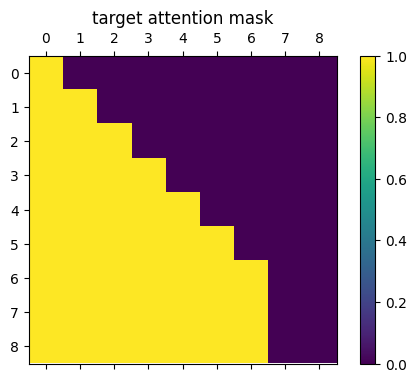

In [21]:
# Target mask example
tgt = torch.Tensor([[1, 2, 3, 4, 5, 6, 7, 0, 0]]).to(device)

tgt_mask = make_tgt_mask(tgt, tgt.size(1))
show_tgt_mask(tgt_mask[0].cpu())

# **Make model**

In [22]:
d_model = 512
n_heads = 8
n_layers = 6
d_ffn = 4*d_model
dropout_p = 0.1

In [23]:
c = copy.deepcopy

src_emb = Embedding(vocab_size, d_model)
tgt_emb = Embedding(vocab_size, d_model)

pos_enc = Positional_encoding(d_model)

mhsa = MultiheadAttention(d_model, n_heads, dropout_p)
FFN = PositionwiseFFN(d_model, d_ffn, dropout_p)

encoder = Encoder(
    EncoderLayer(c(mhsa), c(FFN), d_model, dropout_p),
    src_emb,
    pos_enc,
    n_layers
)
decoder = Decoder(
    DecoderLayer(c(mhsa), c(mhsa), c(FFN), d_model, dropout_p),
    tgt_emb,
    pos_enc,
    n_layers
)

transformer = Transformer(encoder, decoder).to(device)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer

Transformer(
  (encoder): Encoder(
    (emb): Embedding(
      (embedding): Embedding(5000, 512)
    )
    (pos_enc): Positional_encoding()
    (encoder_layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiheadAttention(
          (W_q): Linear(in_features=512, out_features=512, bias=True)
          (W_k): Linear(in_features=512, out_features=512, bias=True)
          (W_v): Linear(in_features=512, out_features=512, bias=True)
          (W_o): Linear(in_features=512, out_features=512, bias=True)
        )
        (FFN): PositionwiseFFN(
          (FFN): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): Sublayer(
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=

In [24]:
pytorch_total_params = sum(p.numel() for p in transformer.parameters() if p.requires_grad)
print("Total model parameters:", pytorch_total_params)

Total model parameters: 51805064


# **Train**

In [25]:
def learning_rate(step, model_size, warmup):
    if step == 0:
        step += 1
    
    return model_size**(-0.5)*min(step**(-0.5), step*warmup**(-1.5))

In [26]:
epochs = 3
lr = 1e-5

# In our case we don't need warmup
# warmup_epochs = 3

In [27]:
optimizer = optim.Adam(transformer.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-09)
criterion = nn.NLLLoss()

# In our case we don't need scheduler
# lr_scheduler = optim.lr_scheduler.LambdaLR(
#     optimizer=optimizer,
#     lr_lambda=lambda step: learning_rate(step, d_model, warmup_epochs)
# )
lr_scheduler = None

In [28]:
for epoch in range(epochs):
    epoch_loss = 0
        
    data_size = len(train_loader.dataset)

    transformer.train()

    for batch in tqdm.tqdm(train_loader, file=sys.stdout):
        src, tgt = batch
        
        src = src.to(device)
        tgt = tgt.to(device)

        decoder_inp = pad_sequence(tgt[:, :-1], batch_first=True)
        decoder_tgt = tgt[:, 1:]

        src_pad_mask = (src != 0).unsqueeze(-2)
        tgt_mask = make_tgt_mask(decoder_inp, decoder_inp.size(1))

        out = transformer(src, decoder_inp, src_pad_mask, tgt_mask)

        loss = criterion(out.contiguous().view(-1, vocab_size),
                         decoder_tgt.contiguous().view(-1))
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

    if lr_scheduler is not None:
        lr_scheduler.step()
        
    train_loss = epoch_loss / (train_data_size // batch_size)

    print(f"Epoch: {epoch}; train_loss: {train_loss}\n")

100%|██████████| 1562/1562 [02:06<00:00, 12.39it/s]
Epoch: 0; train_loss: 2.2658181138975824

100%|██████████| 1562/1562 [02:05<00:00, 12.42it/s]
Epoch: 1; train_loss: 0.2172447419385503

100%|██████████| 1562/1562 [02:04<00:00, 12.51it/s]
Epoch: 2; train_loss: 0.022065614613527896



# **Let's translate (reverse) some sentence**

In [29]:
def predict(model, src):
    model.eval()

    with torch.no_grad():
        src = src.to(device)
        src_pad_mask = (src != 0).unsqueeze(-2)

        preds = torch.ones(src.size(0), 1).type("torch.LongTensor")
        encoder_out = model.encode(src, src_pad_mask)

        for i in range(MAX_SEQ_LEN):
            out = model.decode(
                encoder_out,
                src_pad_mask,
                preds.to(device),
                make_tgt_mask(preds, preds.size(1)).to(device)
            )

            pred_sentence = torch.argmax(out, dim=-1).view(-1)
            pred_word = pred_sentence[-1].cpu()

            preds = torch.cat(
                [preds, torch.LongTensor(pred_word).view(1, -1)],
                dim=1
            )

            if pred_word == 2:
                break

    return preds

In [30]:
src = torch.LongTensor([1, 34, 234, 4563, 439, 368, 4423, 883, 43, 2])
tgt = torch.LongTensor([1, 43, 883, 4423, 368, 439, 4563, 234, 34, 2])

preds = predict(transformer, src.view(1, -1)).view(-1)

print("src        >>", src)
print("target     >>", tgt)
print("prediction >>", preds)

src        >> tensor([   1,   34,  234, 4563,  439,  368, 4423,  883,   43,    2])
target     >> tensor([   1,   43,  883, 4423,  368,  439, 4563,  234,   34,    2])
prediction >> tensor([   1,   43,  883, 4423,  368,  439, 4563,  234,   34,    2])


# **Let's look at the attention weights that the model gave to our query**

In [31]:
def show_attn_weights(attn_weights, layer_name):
    size_1 = attn_weights.size(1)
    size_2 = attn_weights.size(2) 

    attn_weights = attn_weights.view(2, 4, size_1, size_2)
    attn_weights = attn_weights.cpu().detach().numpy()

    f, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), layout="constrained")
    f.suptitle(layer_name, fontsize=16)

    for i in range(2):
        for j in range(4):
            attn_head_weights = ax[i, j].matshow(attn_weights[i, j],
                                                 cmap ='viridis')

            for (p, q), r in np.ndenumerate(attn_weights[i, j]):
                ax[i, j].text(q, p, '{:0.1f}'.format(r),
                              fontsize=10,
                              ha='center',
                              va='center')

            ax[i, j].set_title(f"head {i*2+j+1}", fontsize=12)

## **Encoder layers**


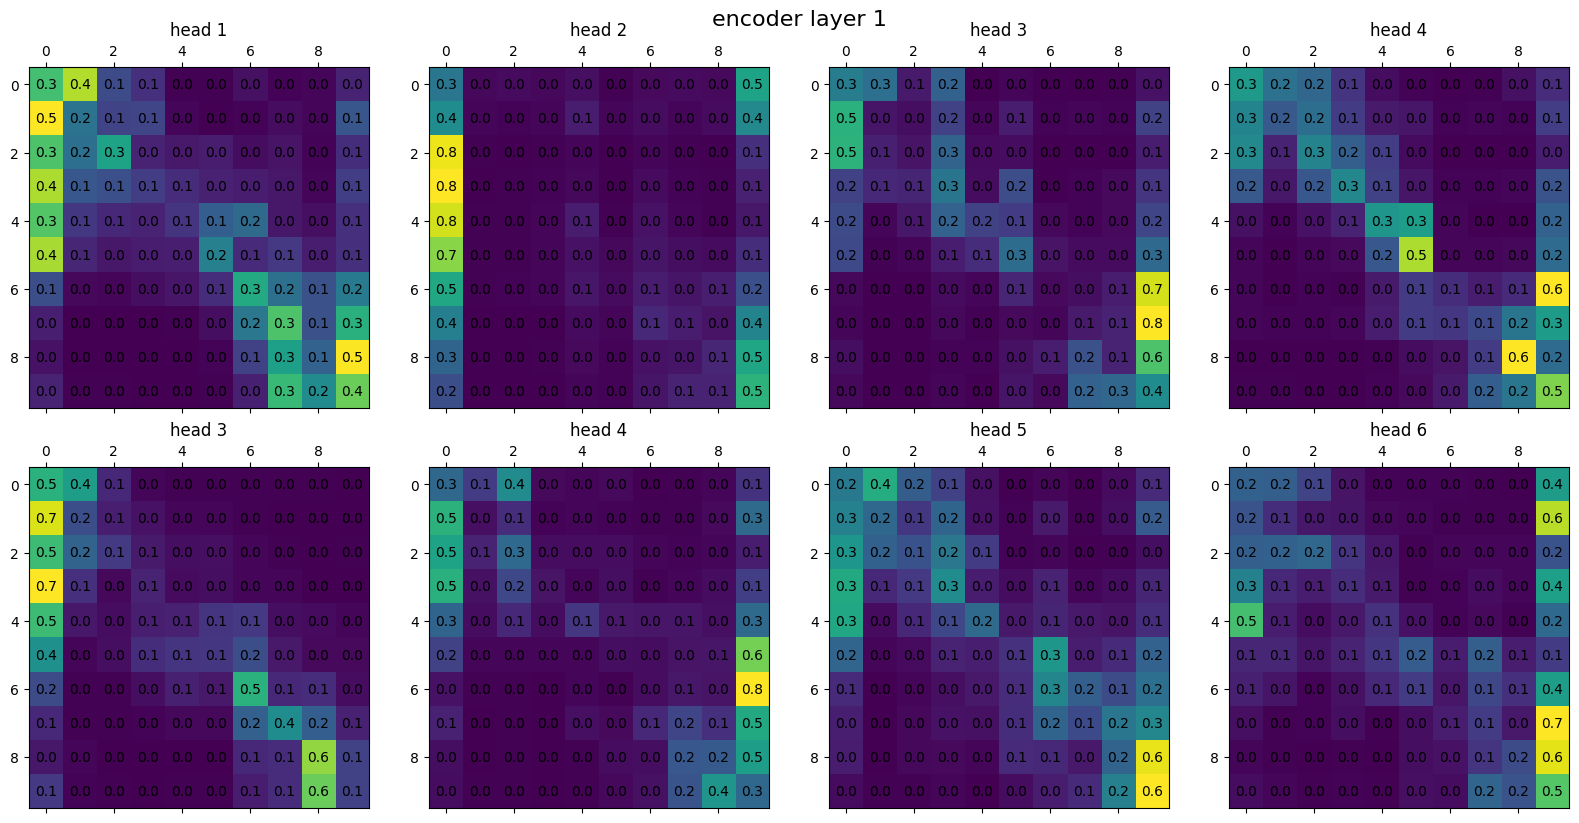

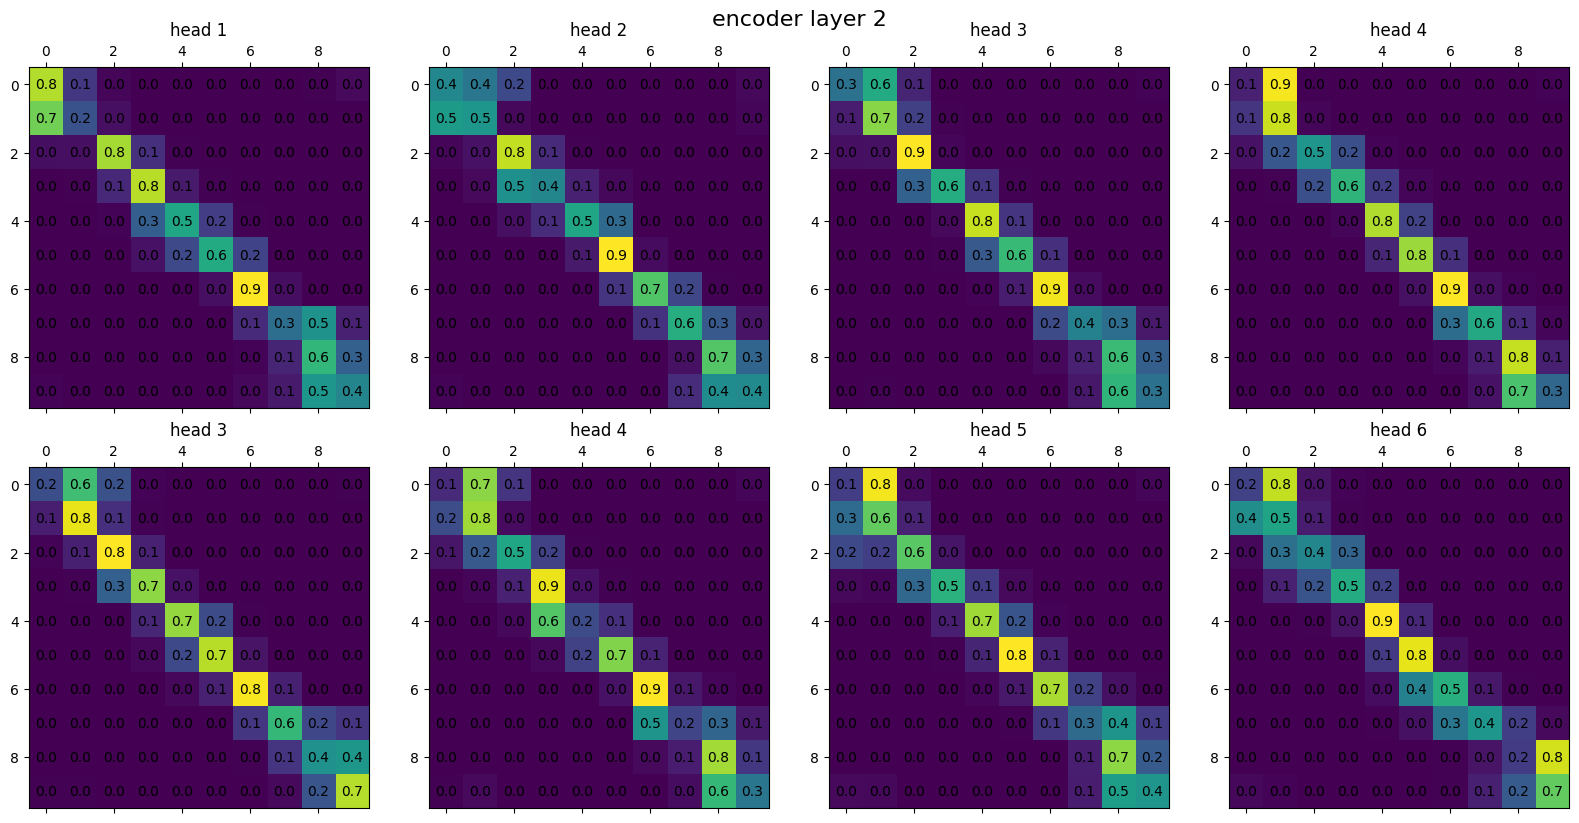

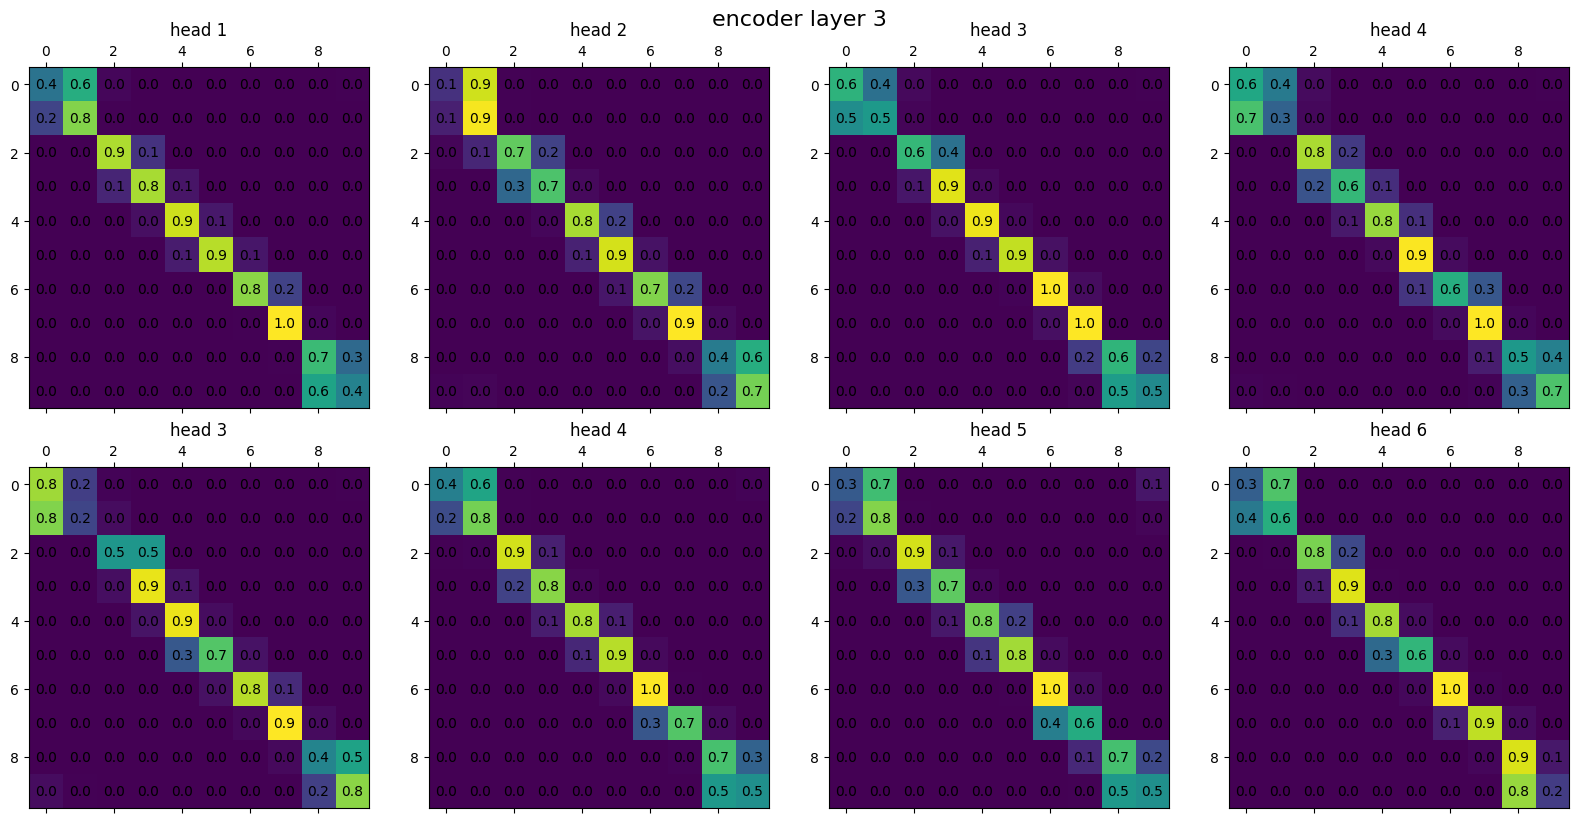

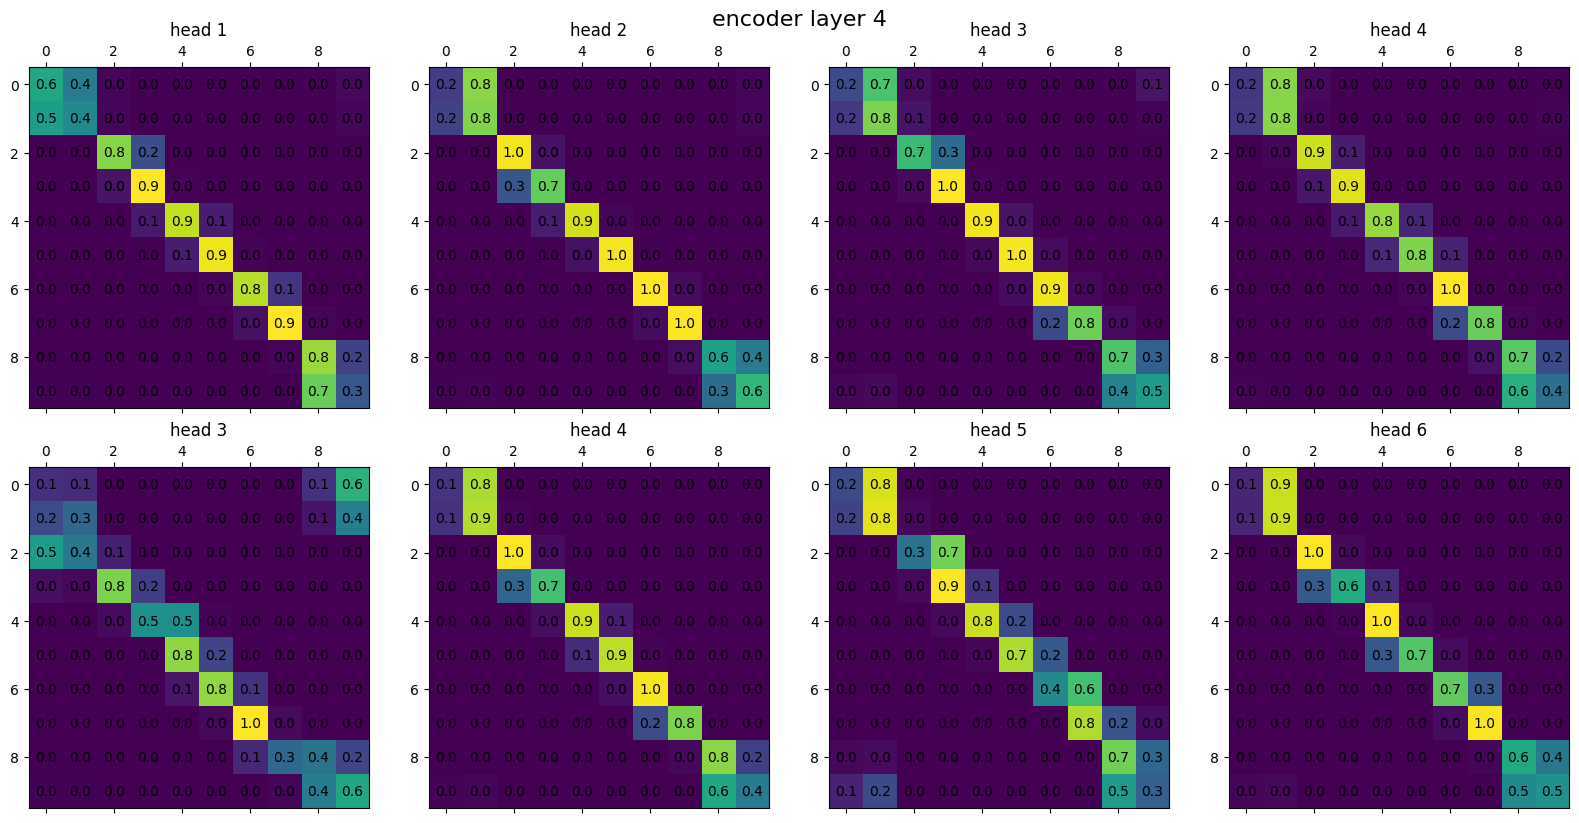

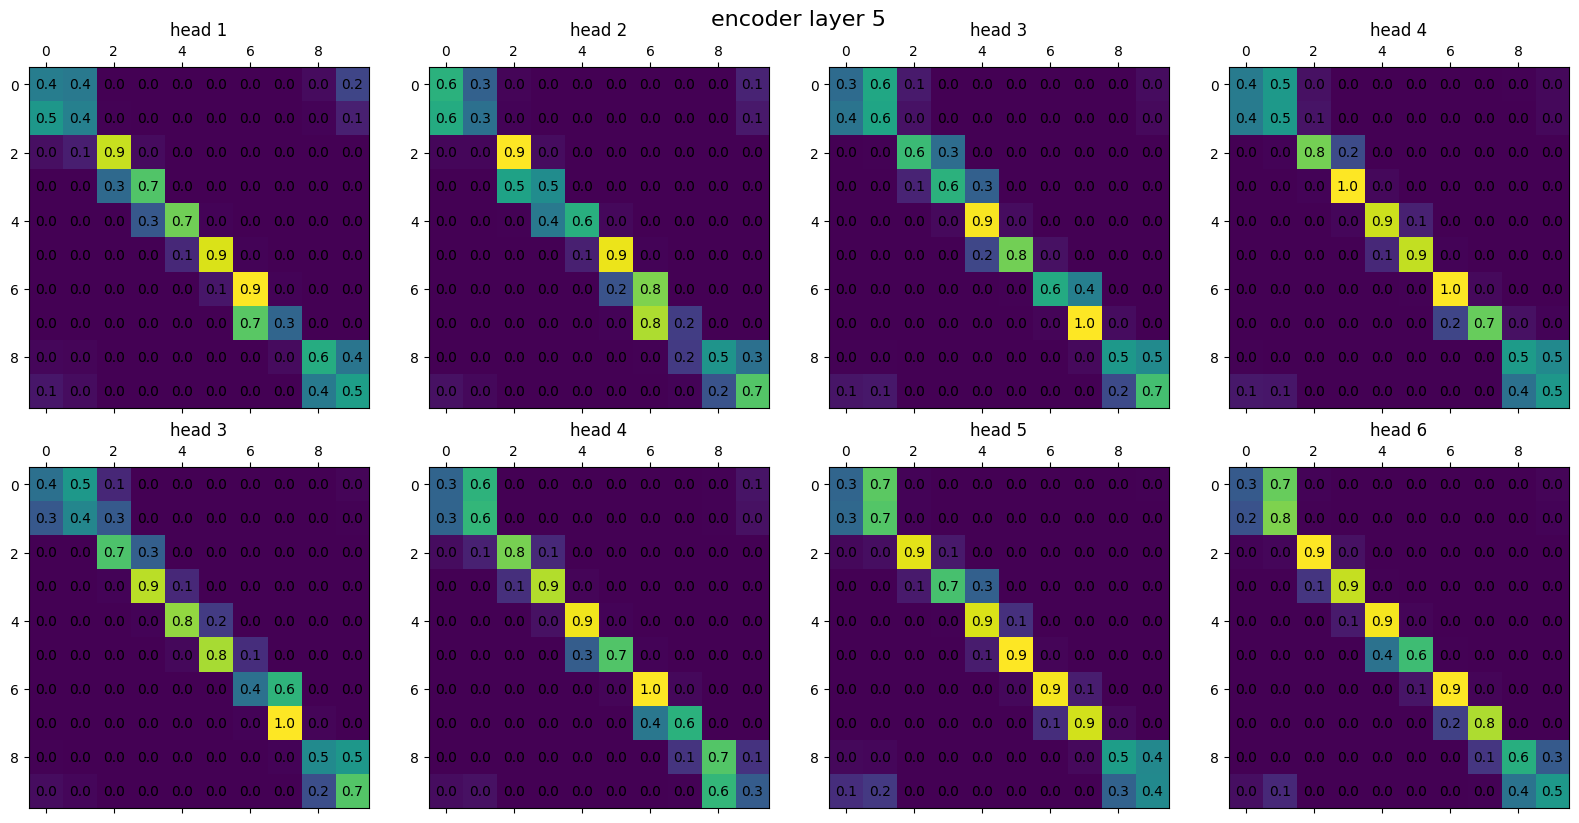

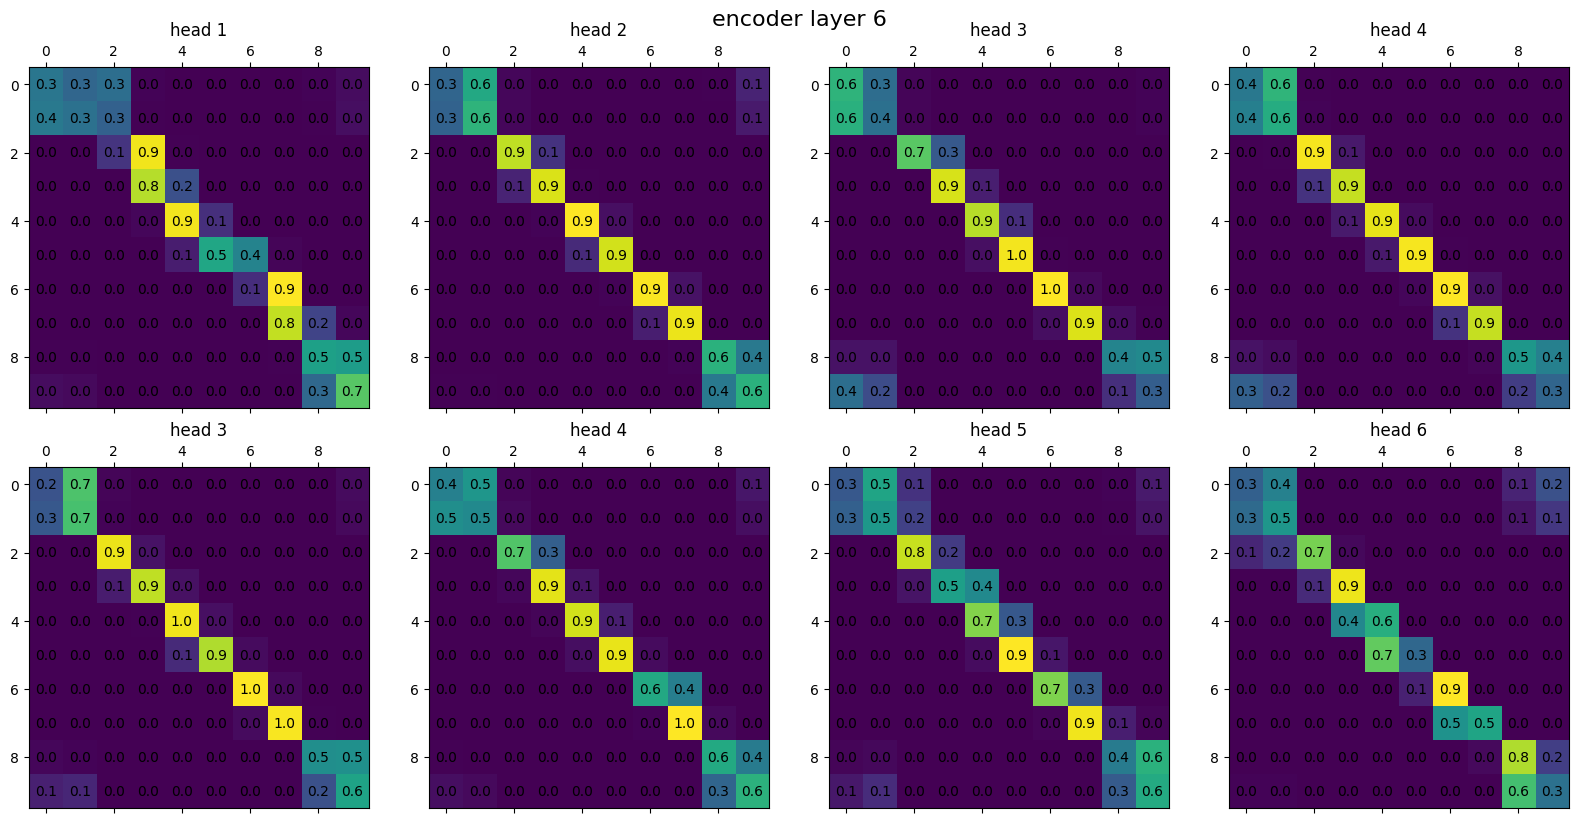

In [32]:
for i, layer in enumerate(transformer.encoder.encoder_layers):
    show_attn_weights(layer.self_attn.attn_weights[0], f"encoder layer {i+1}")

## **Decoder layers**


### **Self-attention**

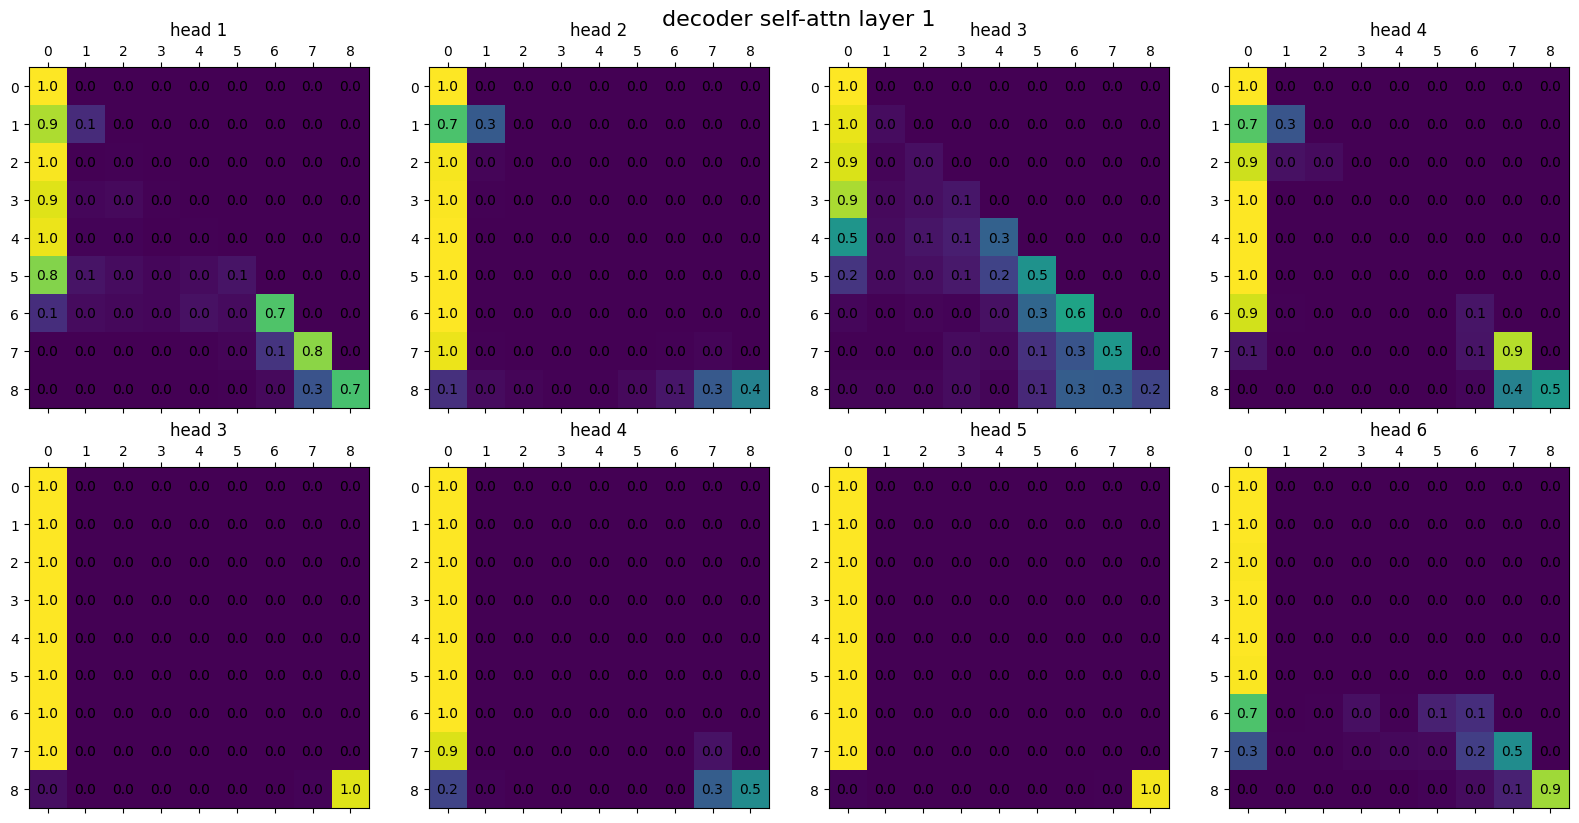

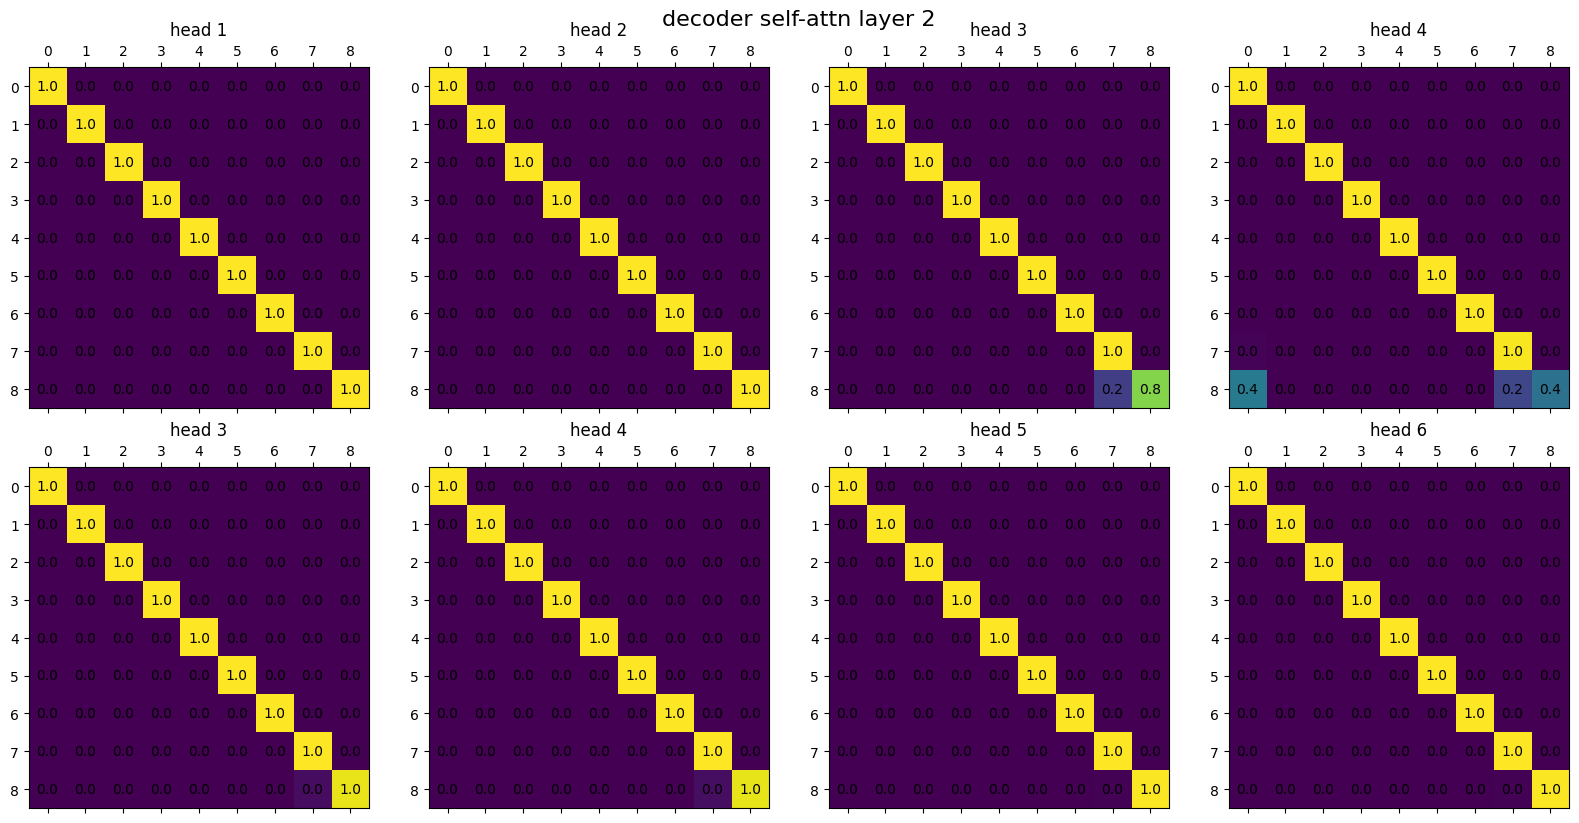

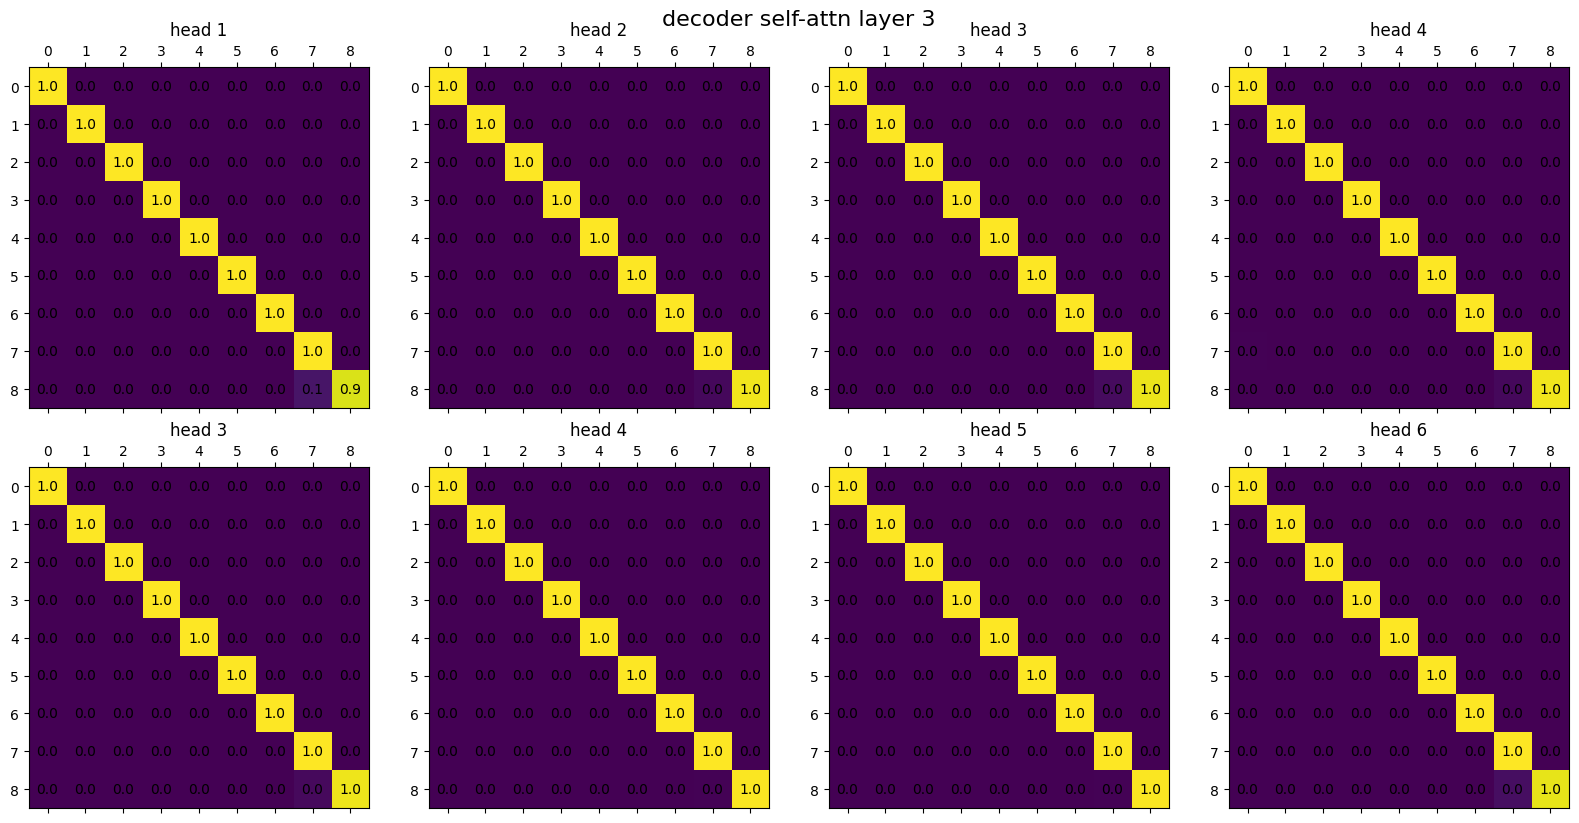

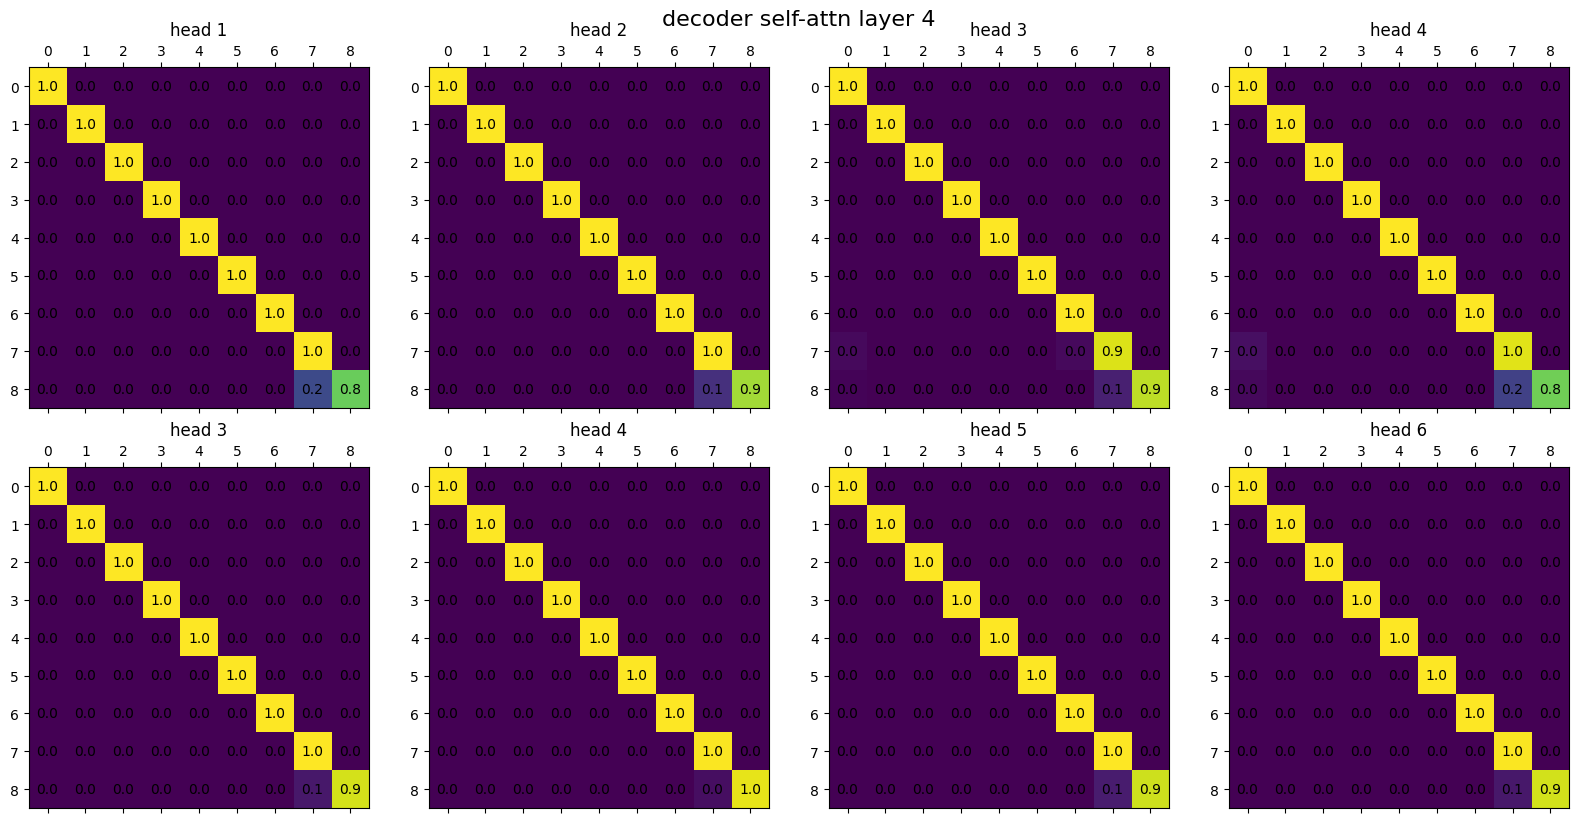

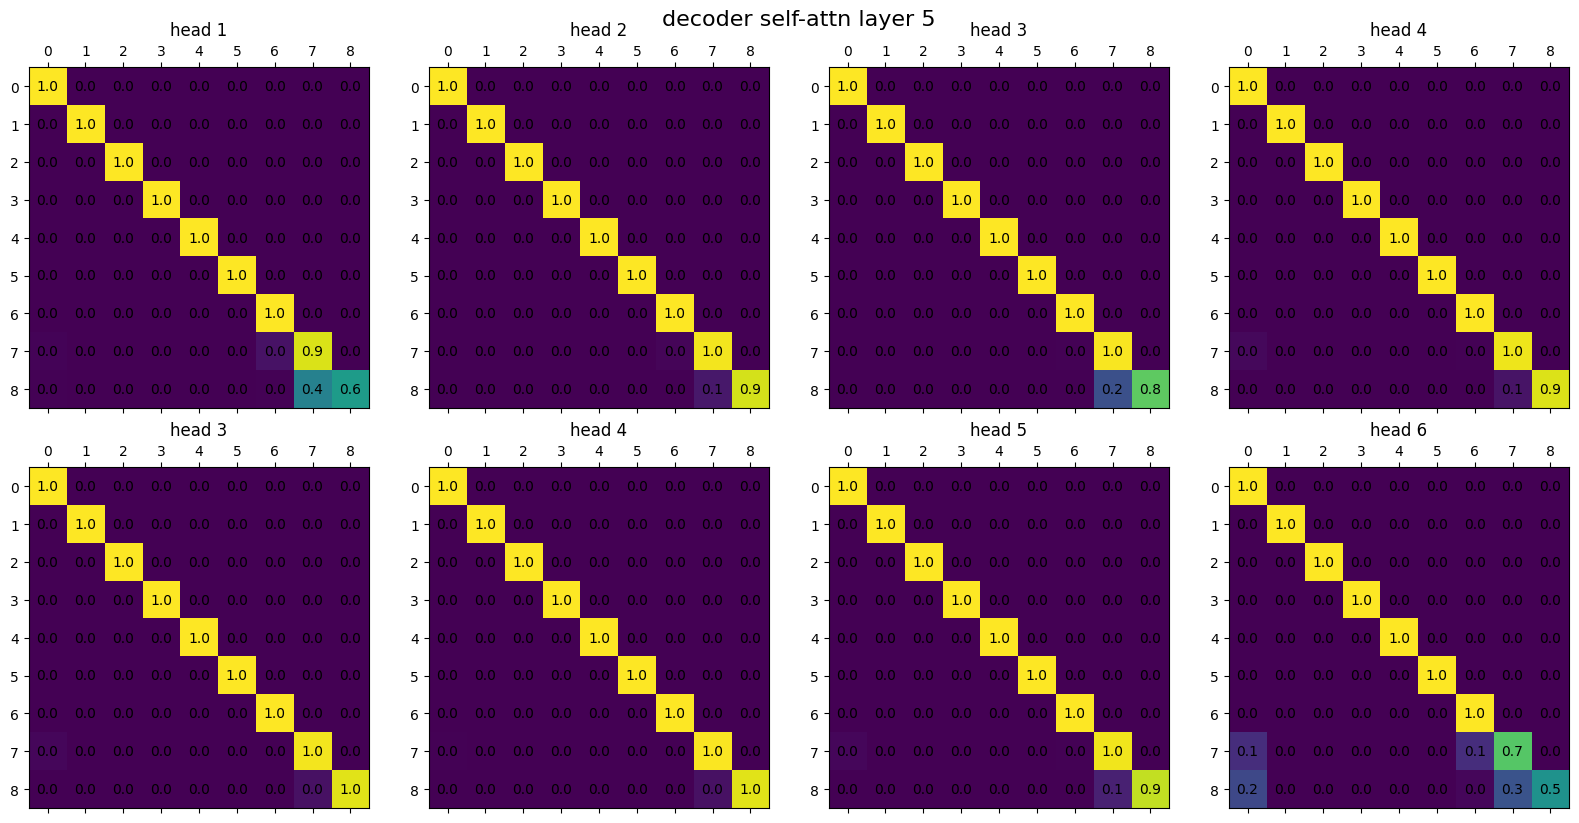

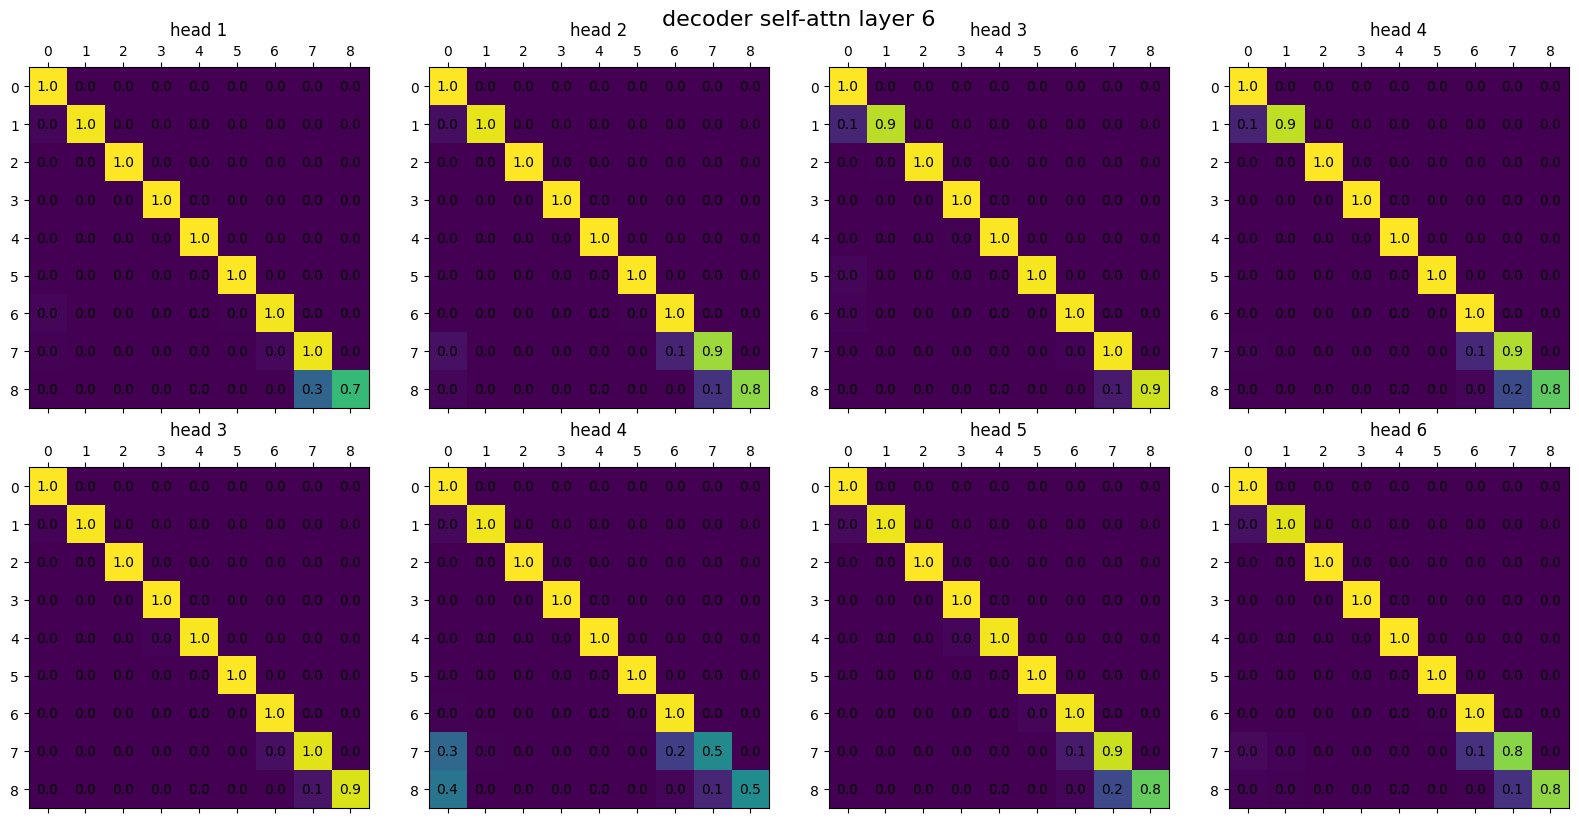

In [33]:
for i, layer in enumerate(transformer.decoder.decoder_layers):
    show_attn_weights(layer.self_attn.attn_weights[0],
                      f"decoder self-attn layer {i+1}")

### **Cross-attention**

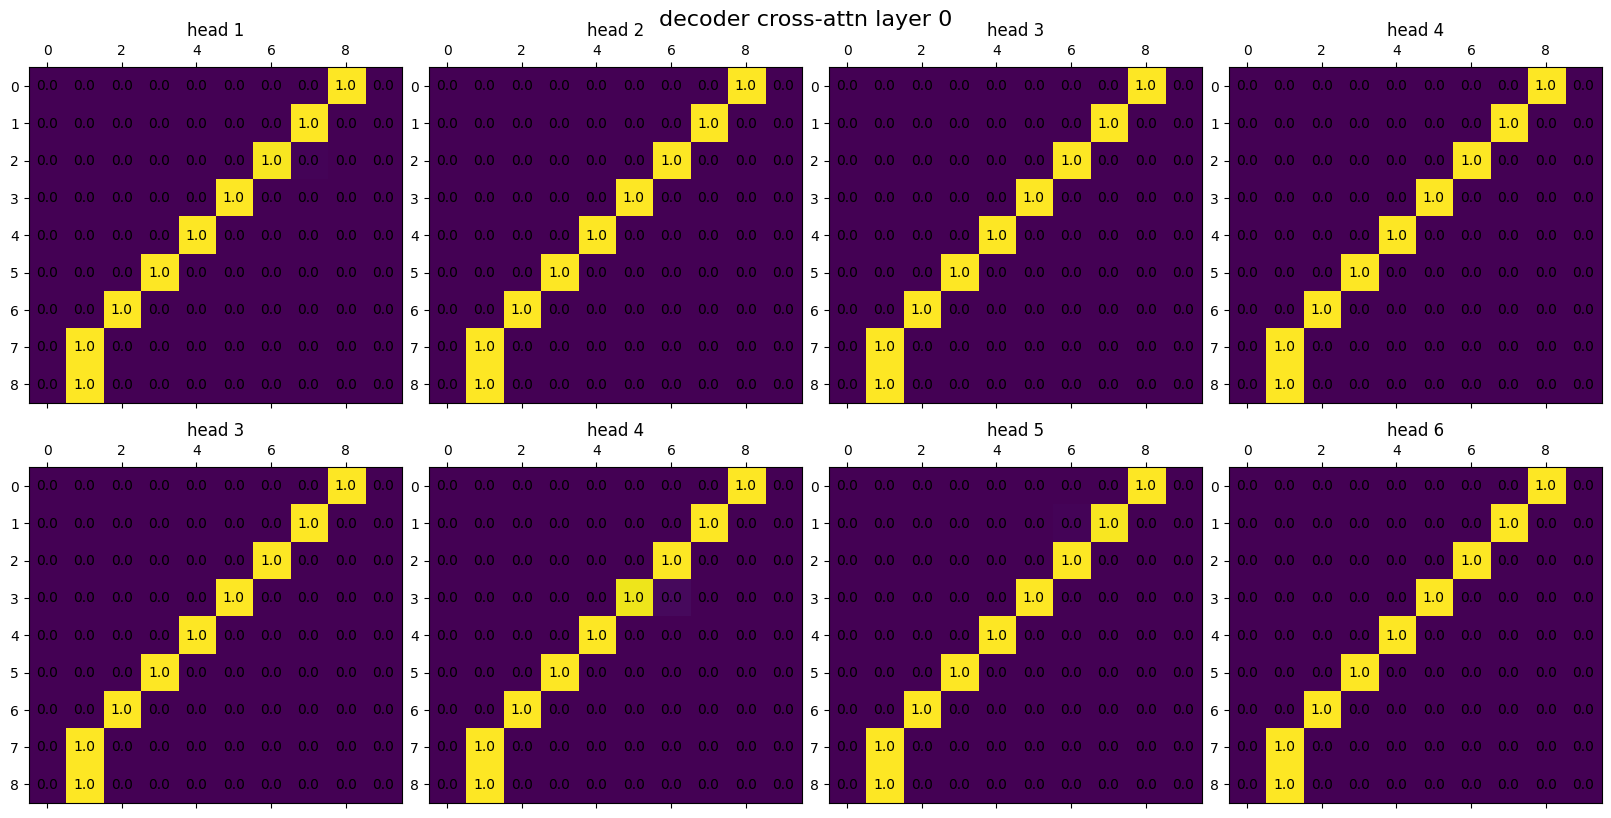

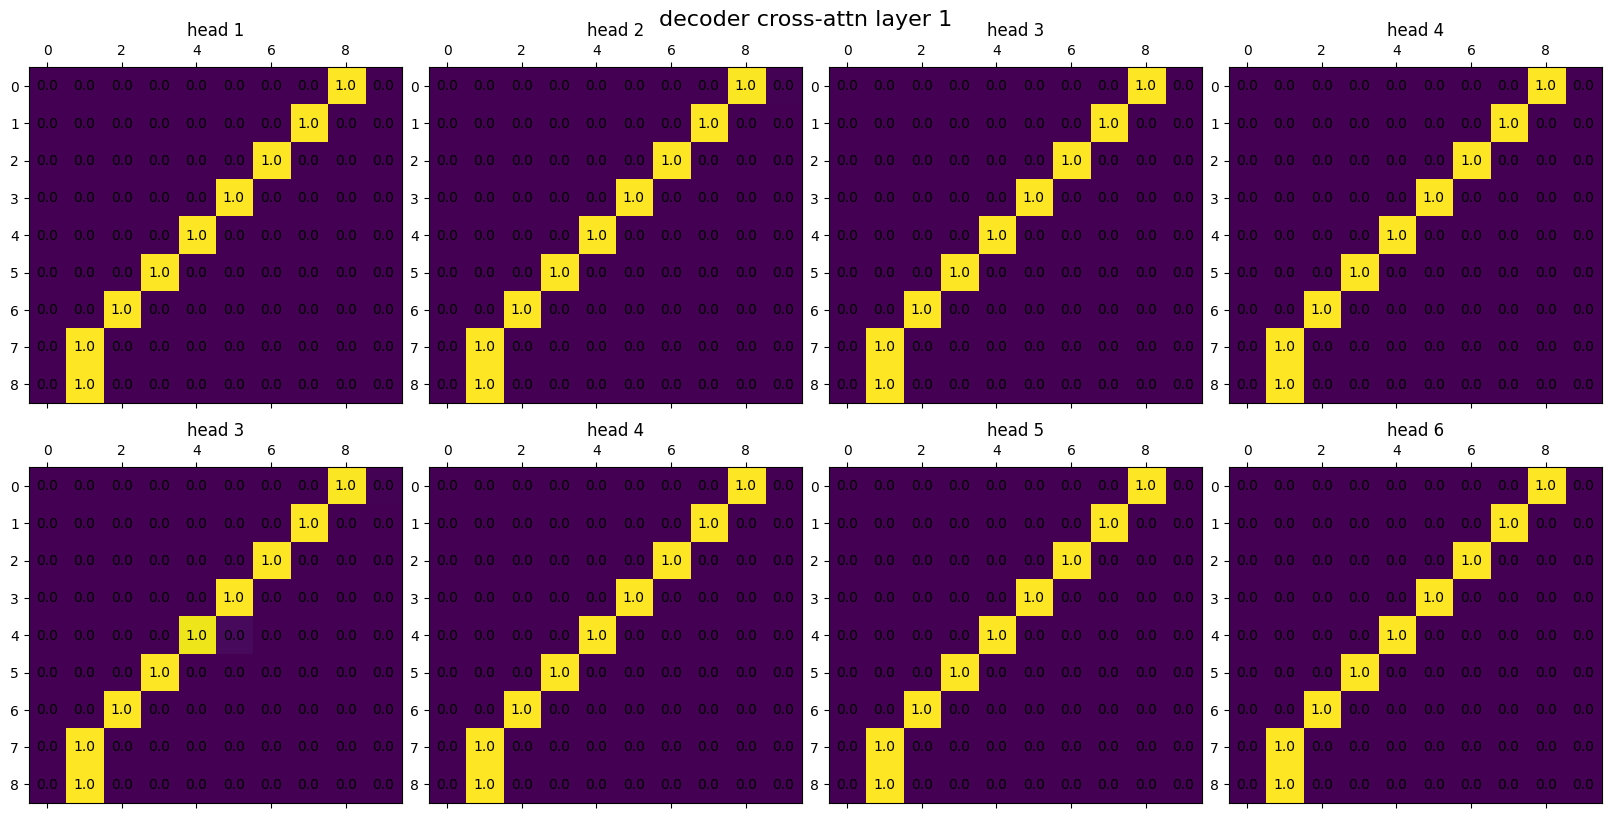

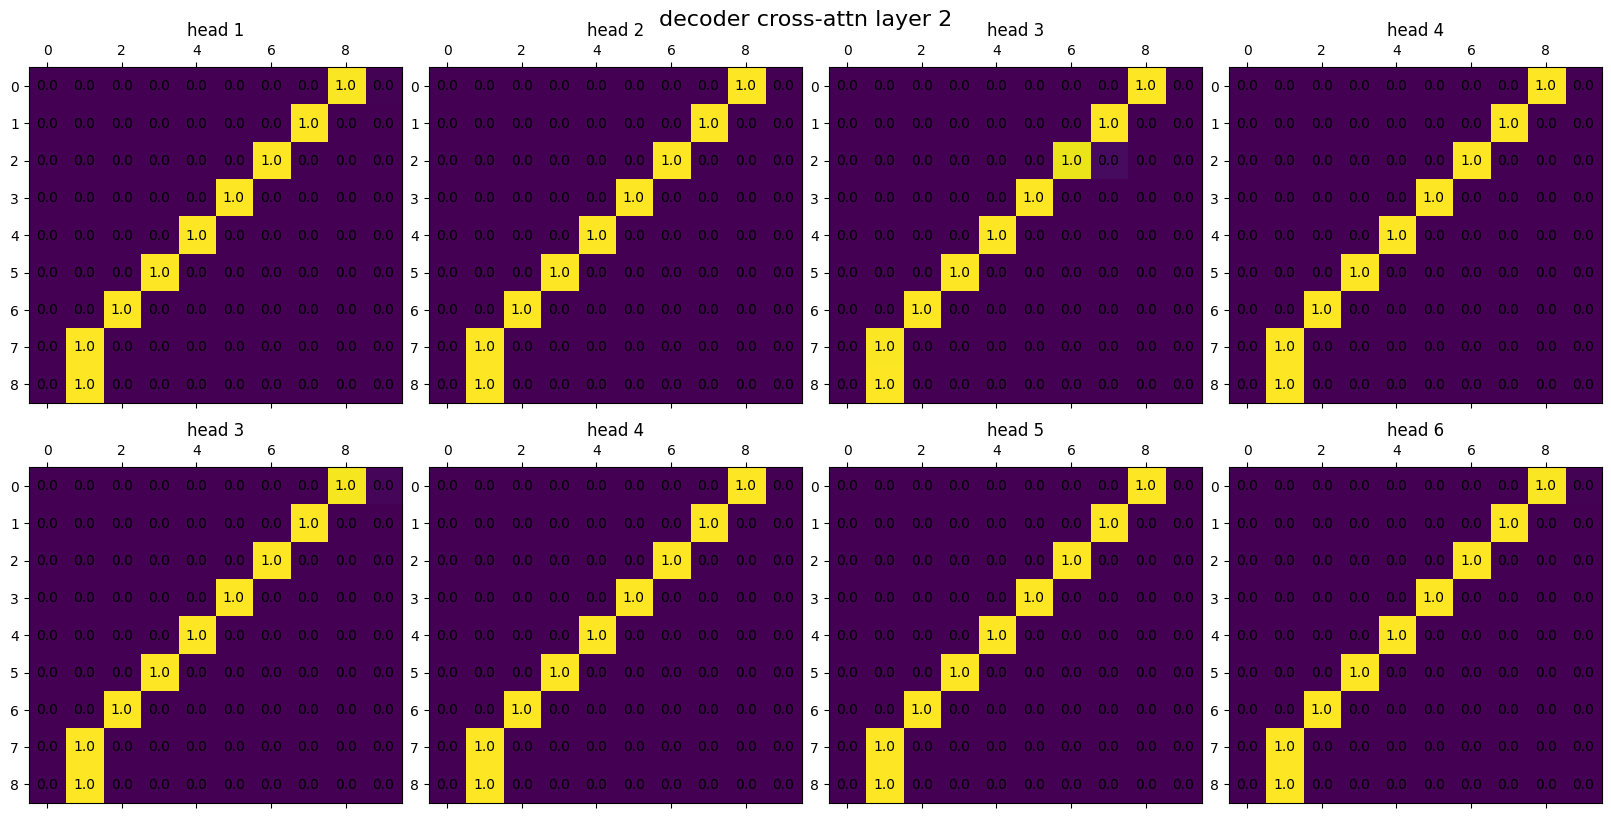

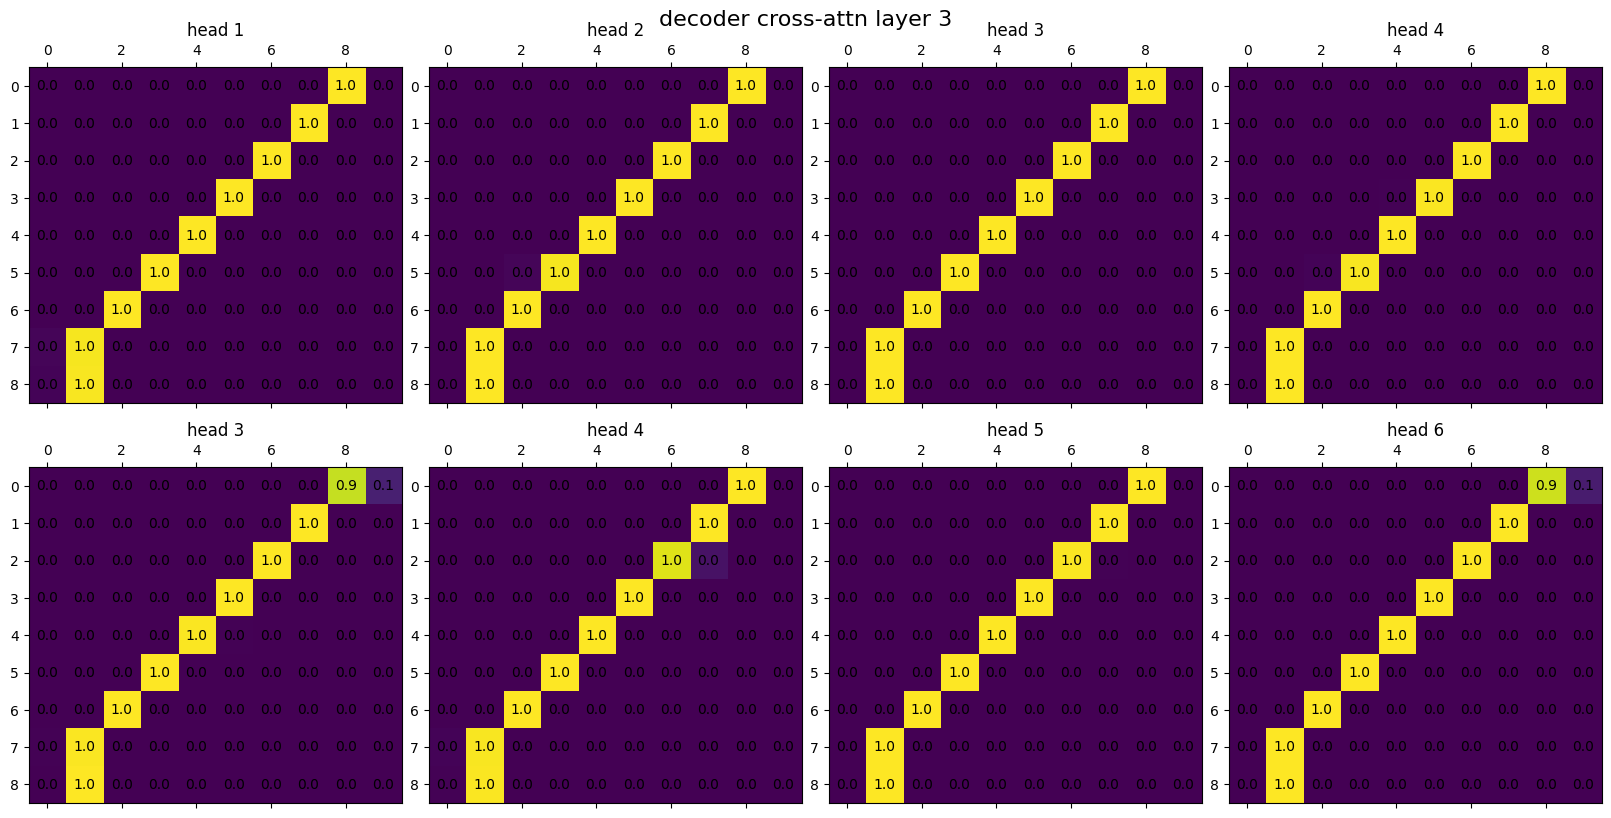

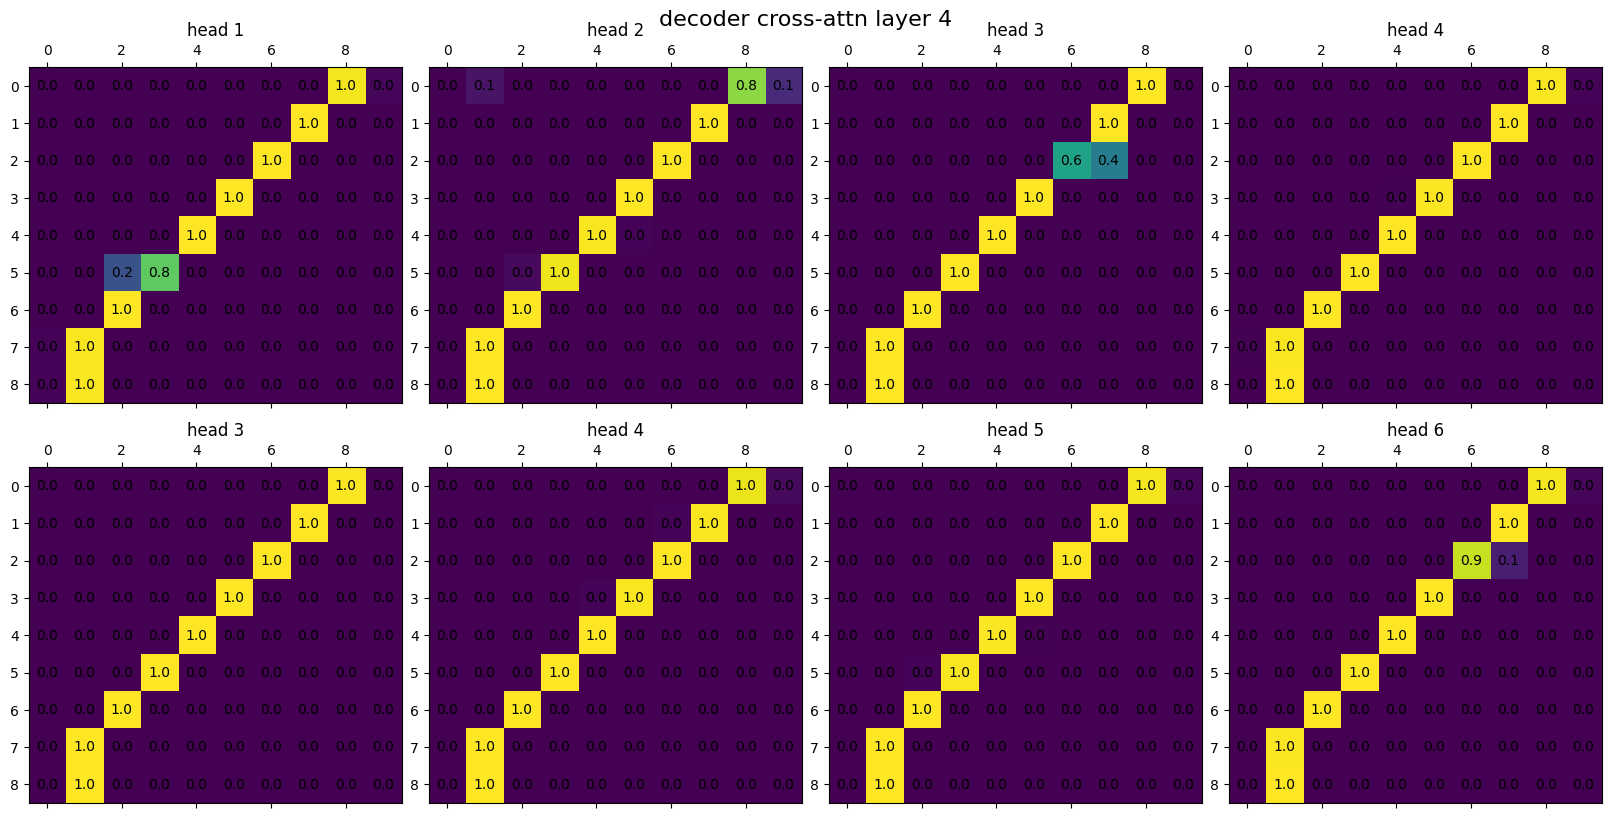

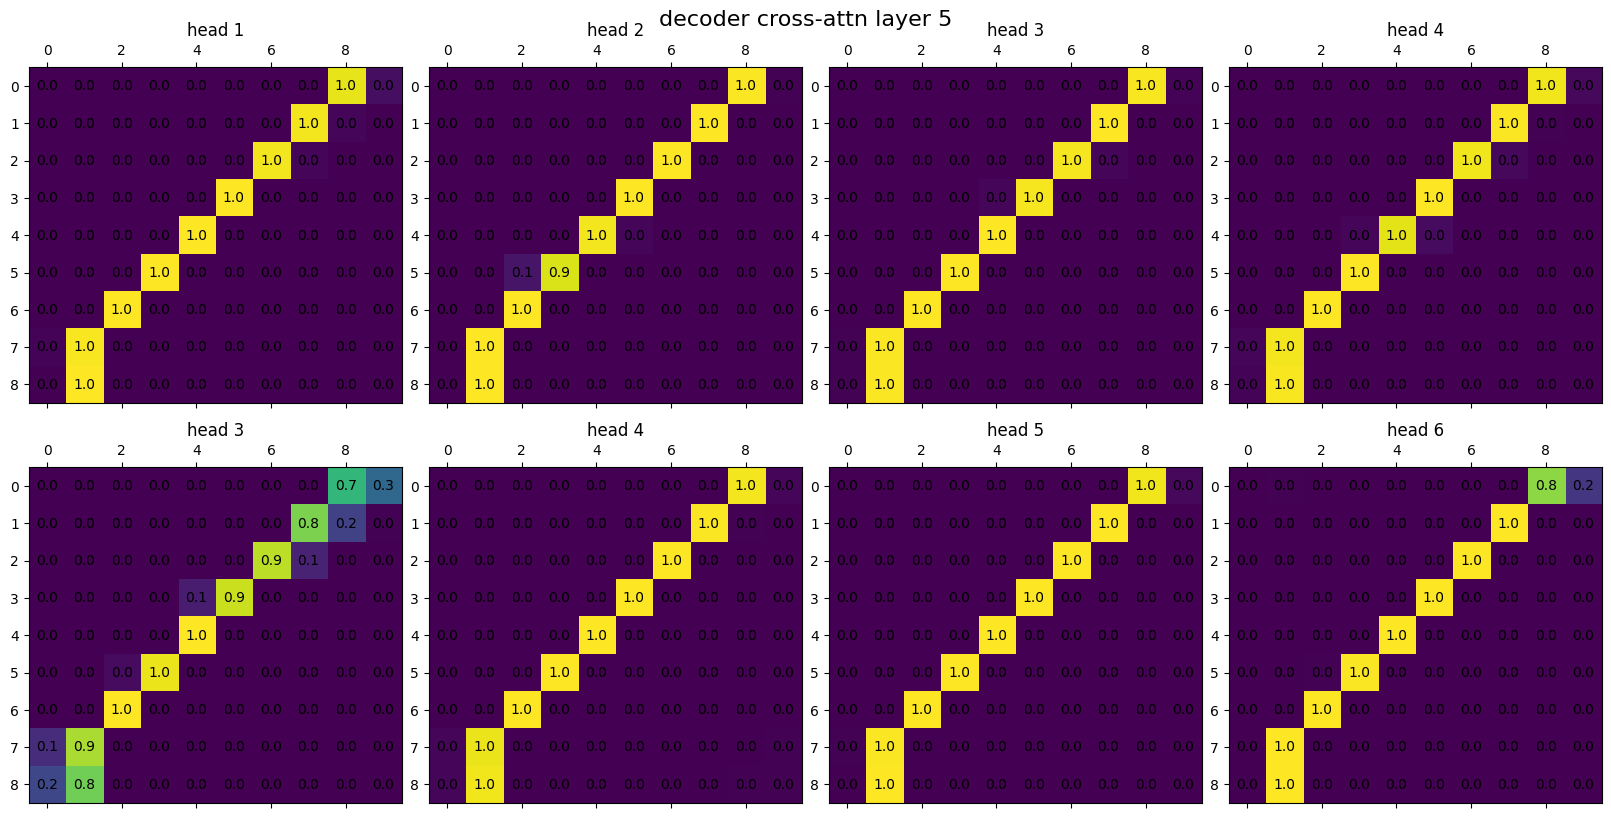

In [34]:
for i, layer in enumerate(transformer.decoder.decoder_layers):
    show_attn_weights(layer.cross_attn.attn_weights[0],
                      f"decoder cross-attn layer {i}")